# MCA Dimensionality Reduction

This technique consider only categorical variables. Some of our variables are numerical (age, weight of the surveyed people, household spent on prepared meals and food to prepare at home, and number of members at home split by kids and adults). Except by the weight, the rest of variables are transformed to categories to be included in the analysis. Additionally, the variables related to the health insurance coverage are put together as one insurance variable.  

The object of correspondence analysis (CA) is to analyze categorical/categorized data that are transformed into cross tables and to demonstrate the results in a graphical manner. In CA, both relations between row and column variables and relations between different levels of each variable can be obtained [2–7]. Some considerations regarding CA are warranted particularly regarding the influence of cells and responses. For instance, some reports have:
- Explored the impact on the analysis by including and excluding/deleting categories 
- Examined methods for identifying columns (attributes) that highlight row (incidence) differences.
Source: https://www.hindawi.com/journals/jar/2013/302163/

Notes: To improve the performance, the category EST was deleted because it adds 50 extra categories.

MCA 

To perform the following technique, we ignore this column and all the variables are converted in categorical (both ordinal and nominal variables are represented by float and int types until now).

In this section, we are focusing on how to apply the MCA reduction dimensionality technique to get a representation of the data points in handle dimensions.

1. Be able to visualize the datapoints in 2D dimensions using different variables as label: In this way, we can find where the datapoints are in the new space and how the variables are connected between them.
2. Be able to explain correlations between the variables and the coordinates generates
3. Visualize the distance between the variables in the hyperplane.



A projection in 2D is not neccesarily the most appropiate when we are investigating correlations and mathematical relations between the variables. 

In [1]:
import pandas as pd
import numpy as np
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math

warnings.filterwarnings("ignore")

In [2]:
import sys
#!{sys.executable} -m pip install kmodes
#!{sys.executable} -m pip install --user prince
from kmodes.kmodes import KModes
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import fcluster
import prince #MCA

# 1. Read the dataset, delete the contextual variables and apply the same preprocessing steps used for the chi-squared statistical tests for feature selection.

In [3]:
df_pulse = pd.read_csv('../data/interim/pulse2020_puf_all.csv')

In [4]:
df_pulse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197365 entries, 0 to 1197364
Columns: 207 entries, SCRAM to depression_disorder
dtypes: bool(2), float64(203), object(2)
memory usage: 1.8+ GB


In [5]:
secondary_columns = [
                    'KINDWORK',
                    'RSNNOWRK',
                    'UNEMPPAY',
                    'FOODSUFRSN1',
                    'FOODSUFRSN2',
                    'FOODSUFRSN3',
                    'FOODSUFRSN4',
                    'FOODSUFRSN5',
                    'WHEREFREE1',
                    'WHEREFREE2',
                    'WHEREFREE3',
                    'WHEREFREE4',
                    'WHEREFREE5',
                    'WHEREFREE6',
                    'WHEREFREE7',
                    'FOODCONF',
                    'MORTLMTH',
                    'MORTCONF',
                    'TEACH1',
                    'TEACH2',
                    'TEACH3',
                    'TEACH4',
                    'TEACH5',
                    'COMPAVAIL',
                    'COMP1',
                    'COMP2',
                    'COMP3',
                    'INTRNTAVAIL',
                    'INTRNT1',
                    'INTRNT2',
                    'INTRNT3',
                    'TSCHLHRS',
                    'TTCH_HRS'
                    ]

In [6]:
print('Number of contextual variables: {}'.format(len(secondary_columns)))

Number of contextual variables: 33


Deleting contextual variables

In [7]:
df_universal = df_pulse.drop(columns=secondary_columns)

As we use `anxiety_disorder` and `depression_disorder` variables, the use of `ANXIOUS`, `INTEREST`, `DOWN` and `WORRY` is redundant.

Drop columns when they have lost up to 50% of information (testing different thresholds)

In [8]:
threshold = int(0.5*len(df_universal))
threshold

598682

In [9]:
df_universal1 = df_universal.dropna(axis=1, thresh=threshold)

Drop id surveyed (SCRAM), WEEK, and variables `ANXIOUS`, `WORRY` (used to estimate the ANXIETY DISORDER) and `DOWN`, `INTEREST` (used to score DEPRESSION DISORDER).

In [10]:
df_universal1.drop(columns=['SCRAM', 'WEEK', 'ANXIOUS', 'WORRY', 'DOWN', 'INTEREST'], inplace=True)

Drop duplicates and missing datapoints

In [11]:
df_universal1.drop_duplicates(inplace=True) #The techniques below explote with missing data!

In [12]:
df_universal1.shape

(1197252, 41)

In [13]:
df_universal1.dropna(inplace=True)

In [14]:
df_universal1.head()

EST_ST      PWEIGHT  ABIRTH_YEAR  EGENDER  AGENDER  RHISPANIC  AHISPANIC  \
0    47.0  1973.489532          2.0      2.0      2.0        1.0        2.0   
2    26.0  1526.612380          2.0      2.0      2.0        1.0        2.0   
3     1.0  2734.635354          2.0      1.0      2.0        1.0        2.0   
4     1.0   681.211425          2.0      2.0      2.0        1.0        2.0   
6     1.0  1647.093908          2.0      2.0      2.0        1.0        2.0   

   RRACE  ARACE  EEDUC  ...  HLTHINS6  HLTHINS7  HLTHINS8  DELAY  NOTGET  \
0    1.0    2.0    6.0  ...       2.0       2.0       2.0    2.0     2.0   
2    4.0    2.0    6.0  ...       2.0       2.0       2.0    1.0     1.0   
3    1.0    2.0    4.0  ...       2.0       2.0       1.0    1.0     1.0   
4    1.0    2.0    7.0  ...       2.0       2.0       2.0    2.0     2.0   
6    2.0    2.0    7.0  ...       2.0       2.0       2.0    2.0     2.0   

   TENURE  INCOME   AGE  anxiety_disorder  depression_disorder  
0     3.0     4.0  34.0              True                False  
2     2.0     8.0  44.0             False                False  
3     2.0     1.0  56.0              True                 True  
4     2.0     4.0  57.0             False                False  
6     3.0     4.0  37.0             False                False  

[5 rows x 41 columns]

Sampling data (the advantage of PCA is that it's computationally cheap related to other techniques. To avoid explosions, we use a sample of the dataset).

In [15]:
Xsample = df_universal1.sample(10000, random_state=42)

# 2. Transformation of variables

In [16]:
Xsample.columns

Index(['EST_ST', 'PWEIGHT', 'ABIRTH_YEAR', 'EGENDER', 'AGENDER', 'RHISPANIC',
       'AHISPANIC', 'RRACE', 'ARACE', 'EEDUC', 'AEDUC', 'MS', 'THHLD_NUMPER',
       'AHHLD_NUMPER', 'THHLD_NUMKID', 'AHHLD_NUMKID', 'THHLD_NUMADLT',
       'WRKLOSS', 'EXPCTLOSS', 'ANYWORK', 'PRIFOODSUF', 'CURFOODSUF',
       'FREEFOOD', 'TSPNDFOOD', 'TSPNDPRPD', 'HLTHSTATUS', 'HLTHINS1',
       'HLTHINS2', 'HLTHINS3', 'HLTHINS4', 'HLTHINS5', 'HLTHINS6', 'HLTHINS7',
       'HLTHINS8', 'DELAY', 'NOTGET', 'TENURE', 'INCOME', 'AGE',
       'anxiety_disorder', 'depression_disorder'],
      dtype='object')

In [17]:
# Delete flag variables
flag_allocation = ['ABIRTH_YEAR', 'AGENDER', 'AHISPANIC', 'ARACE', 'AEDUC', 'AHHLD_NUMPER', 'AHHLD_NUMKID']
Xsample.drop(columns=flag_allocation, inplace=True)

In [18]:
#dataset for MCA
Xs = Xsample.reset_index(drop=True)

Let's inpect the data:

1. Number of variables
2. Sum of categorical variables

In [19]:
Xs.columns

Index(['EST_ST', 'PWEIGHT', 'EGENDER', 'RHISPANIC', 'RRACE', 'EEDUC', 'MS',
       'THHLD_NUMPER', 'THHLD_NUMKID', 'THHLD_NUMADLT', 'WRKLOSS', 'EXPCTLOSS',
       'ANYWORK', 'PRIFOODSUF', 'CURFOODSUF', 'FREEFOOD', 'TSPNDFOOD',
       'TSPNDPRPD', 'HLTHSTATUS', 'HLTHINS1', 'HLTHINS2', 'HLTHINS3',
       'HLTHINS4', 'HLTHINS5', 'HLTHINS6', 'HLTHINS7', 'HLTHINS8', 'DELAY',
       'NOTGET', 'TENURE', 'INCOME', 'AGE', 'anxiety_disorder',
       'depression_disorder'],
      dtype='object')

In [20]:
Xs.loc[:, 'HLTHINS1':'HLTHINS8']

HLTHINS1  HLTHINS2  HLTHINS3  HLTHINS4  HLTHINS5  HLTHINS6  HLTHINS7  \
0          2.0       1.0       1.0       2.0       2.0       2.0       2.0   
1          2.0       2.0       1.0       2.0       2.0       2.0       2.0   
2          1.0       2.0       2.0       2.0       2.0       2.0       2.0   
3          2.0       2.0       2.0       2.0       2.0       2.0       2.0   
4          2.0       1.0       1.0       2.0       2.0       1.0       2.0   
...        ...       ...       ...       ...       ...       ...       ...   
9995       2.0       2.0       2.0       1.0       1.0       1.0       2.0   
9996       1.0       2.0       2.0       2.0       2.0       2.0       2.0   
9997       1.0       1.0       2.0       2.0       2.0       2.0       2.0   
9998       1.0       1.0       1.0       2.0       2.0       2.0       2.0   
9999       1.0       1.0       2.0       2.0       2.0       2.0       2.0   

      HLTHINS8  
0          2.0  
1          2.0  
2          2.0  
3          2.0  
4          2.0  
...        ...  
9995       2.0  
9996       2.0  
9997       2.0  
9998       2.0  
9999       2.0  

[10000 rows x 8 columns]

In [21]:
x = Xs.loc[:, 'HLTHINS1':'HLTHINS8'].idxmax(axis=1)
Xs['HLTHINS'] = x
Xs.drop(columns=['HLTHINS1','HLTHINS2',
                 'HLTHINS3','HLTHINS4',
                 'HLTHINS5','HLTHINS6',
                 'HLTHINS7','HLTHINS8'], inplace=True)

In [22]:
Xsample.THHLD_NUMPER.unique()

array([ 2.,  1.,  3.,  5.,  7.,  4.,  6., 10.,  8.,  9.])

In [23]:
Xsample.THHLD_NUMADLT.unique()

array([ 2.,  1.,  5.,  3.,  4.,  6., 10.,  7.,  9.,  8.])

In [24]:
Xsample.THHLD_NUMKID.unique()

array([0., 1., 5., 2., 4., 3.])

(array([1673., 3520., 1792., 1699.,  763.,  283.,  110.,   57.,   20.,
          83.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

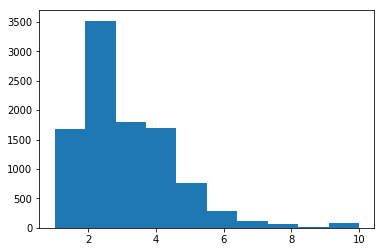

In [25]:
plt.hist(Xsample.THHLD_NUMPER)

(array([2.177e+03, 5.500e+03, 1.464e+03, 5.650e+02, 1.680e+02, 4.400e+01,
        1.400e+01, 5.000e+00, 1.100e+01, 5.200e+01]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

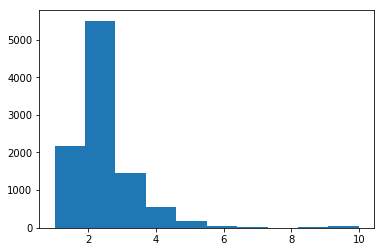

In [26]:
plt.hist(Xsample.THHLD_NUMADLT)

(array([6280.,    0., 1607.,    0., 1347.,    0.,  513.,    0.,  161.,
          92.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

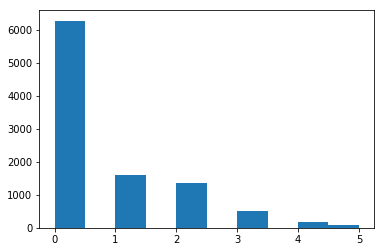

In [27]:
plt.hist(Xsample.THHLD_NUMKID)

In [28]:
def reduce_categories(column):
    #split in 5 categories
    if column < 2:
        return 1.0
    elif (column >= 2) &  (column < 5):
        return 2.0
    elif (column >= 5) &  (column < 7):
        return 3.0
    elif (column >= 7) &  (column < 9):
        return 4.0
    else:
        return 5.0

In [29]:
Xs['NUMADLT'] = Xs.THHLD_NUMADLT.apply(reduce_categories)
Xs['NUMPER'] = Xs.THHLD_NUMPER.apply(reduce_categories)

Xs.drop(columns=['THHLD_NUMPER', 'THHLD_NUMADLT'], inplace=True)

In [30]:
def reduce_categories_food1(column):
    #split in 5 categories
    bins=5
    max_value=900
    thres = int(max_value/bins)
    if column < thres:
        return 1.0
    elif (column >= thres) &  (column < 2*thres):
        return 2.0
    elif (column >= 2*thres) &  (column < 3*thres):
        return 3.0
    elif (column >= 4*thres) &  (column < 5*thres):
        return 4.0
    else:
        return 5.0

In [31]:
def reduce_categories_food2(column):
    #split in 5 categories
    bins=5
    max_value=500
    thres = int(max_value/bins)
    if column < thres:
        return 1.0
    elif (column >= thres) &  (column < 2*thres):
        return 2.0
    elif (column >= 2*thres) &  (column < 3*thres):
        return 3.0
    elif (column >= 4*thres) &  (column < 5*thres):
        return 4.0
    else:
        return 5.0

(array([1811., 3531., 2588., 1086.,  418.,  316.,  101.,   42.,   47.,
          60.]),
 array([  0.,  90., 180., 270., 360., 450., 540., 630., 720., 810., 900.]),
 <a list of 10 Patch objects>)

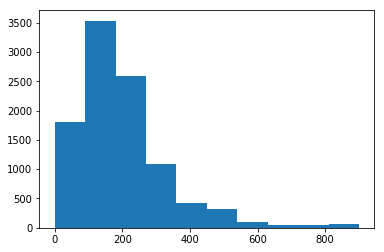

In [32]:
plt.hist(Xsample.TSPNDFOOD)

(array([4852., 2240., 1471.,  497.,  459.,  112.,  171.,   34.,   67.,
          97.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]),
 <a list of 10 Patch objects>)

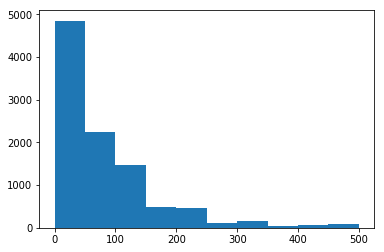

In [33]:
plt.hist(Xsample.TSPNDPRPD)

In [34]:
Xs['TSPFOOD'] = Xs.TSPNDFOOD.apply(reduce_categories_food1)
Xs['TSPPRPD'] = Xs.TSPNDPRPD.apply(reduce_categories_food2)

Xs.drop(columns=['TSPNDFOOD', 'TSPNDPRPD'], inplace=True)

(array([ 291.,  847., 1475., 1613., 1391., 1389., 1302., 1071.,  475.,
         146.]),
 array([18., 25., 32., 39., 46., 53., 60., 67., 74., 81., 88.]),
 <a list of 10 Patch objects>)

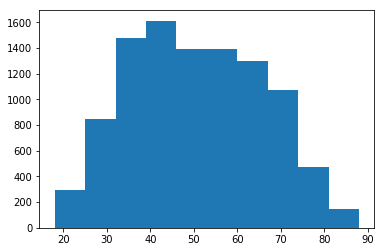

In [35]:
plt.hist(Xsample.AGE)

In [36]:
def bins_age(column):
    #split in 4 categories
    thres = 36
    if column < 36:
        return 1.0
    elif (column >= 36) &  (column < 54):
        return 2.0
    elif (column >= 54) &  (column < 72):
        return 3.0
    else:
        return 4.0

In [37]:
Xs['AGE_CAT'] = Xs.AGE.apply(bins_age)
Xs.drop(columns=['AGE'], inplace=True)

In [38]:
Xs['AGE_CAT'].unique()

array([4., 2., 1., 3.])

In [39]:
Xs = Xs.rename(columns={'anxiety_disorder': 'ANXIETY', 'depression_disorder': 'DEPRESSION'})

# 3. MCA using all the variables (no Delete Anxiety and Depression variables)

In [40]:
X_cat = Xs.drop(columns=['PWEIGHT', 'EST_ST']) #delete the continuous variables and states
df=X_cat.copy()

for var in df.columns:
    df[var]=df[var].astype('category')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   EGENDER       10000 non-null  category
 1   RHISPANIC     10000 non-null  category
 2   RRACE         10000 non-null  category
 3   EEDUC         10000 non-null  category
 4   MS            10000 non-null  category
 5   THHLD_NUMKID  10000 non-null  category
 6   WRKLOSS       10000 non-null  category
 7   EXPCTLOSS     10000 non-null  category
 8   ANYWORK       10000 non-null  category
 9   PRIFOODSUF    10000 non-null  category
 10  CURFOODSUF    10000 non-null  category
 11  FREEFOOD      10000 non-null  category
 12  HLTHSTATUS    10000 non-null  category
 13  DELAY         10000 non-null  category
 14  NOTGET        10000 non-null  category
 15  TENURE        10000 non-null  category
 16  INCOME        10000 non-null  category
 17  ANXIETY       10000 non-null  category
 18  DEPRESS

In [42]:
total_variables = df.shape[1]

In [43]:
total_categories = 0
for col in df.columns:
    total_categories += df[col].unique().shape[0]  
    
print('Number of categories: {}'.format(total_categories))

Number of categories: 98


In [44]:
max_dimensions = total_categories-total_variables

In [45]:
print('Max number of dimensions: {}'.format(max_dimensions))

Max number of dimensions: 73


In [46]:
total_inertia = max_dimensions/total_variables
print('Total inertia: {}'.format(total_inertia))

Total inertia: 2.92


This step allow exploring the number of dimensions to be included in the analysis and to obtain the reference value for total inertia (meaning that the contribution of each factor should now be calculated using the total inertia score as the denominator). The main use of inertia is as an indicator of the number of axes to retain for further analysis.

To define the number of dimensions to retain, the following criteria/considerations were employed: (i) eigenvalue (inclusion of MCA dimensions with inertia above 0.2 and (iv) although no defined number of dimensions is firmly established, some authors recommend two-dimensional pictures of data (which facilitates and allows for data interpretation).

In [47]:
#selected_variables = ['WRKLOSS','EXPCTLOSS','CURFOODSUF', 'DELAY','NOTGET', 'TENURE', 'INCOME', 'anxiety_disorder']
selected_variables = df.columns #all

In [48]:
df1 = df.loc[:, selected_variables]

In [49]:
mca_ex = prince.MCA(n_components=2, n_iter=3, engine='auto', random_state=42)
mca_ex = mca_ex.fit(df1) # same as calling ca.fs_r(1)
dfmca = mca_ex.transform(df1) # same as calling ca.fs_r_sup(df_new) for *another* test set.
#print(dfmca)

In [50]:
mca_ex.eigenvalues_

[0.16452769930148092, 0.12500345546692898]

In [51]:
mca_ex.total_inertia_

2.92

In [52]:
mca_ex.explained_inertia_

[0.056345102500507165, 0.04280940255716746]

## 3.1 Analysis of variables and graphs

In [53]:
def euclidian_distance(x, y):
    return math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))

In [54]:
df_variables_mca = mca_ex.column_coordinates(df1)

### 3.1.1 Column coordinates

In [55]:
df_variables_mca.head(20)

0         1
EGENDER_1.0   -0.164398 -0.083720
EGENDER_2.0    0.115048  0.058588
RHISPANIC_1.0 -0.043648 -0.052685
RHISPANIC_2.0  0.481595  0.581311
RRACE_1.0     -0.078348 -0.068986
RRACE_2.0      0.680690  0.290065
RRACE_3.0     -0.365198  0.305541
RRACE_4.0      0.687377  0.468930
EEDUC_1.0      1.531395  0.916602
EEDUC_2.0      1.212798  0.828538
EEDUC_3.0      0.616885  0.001859
EEDUC_4.0      0.407333  0.019827
EEDUC_5.0      0.238389 -0.031600
EEDUC_6.0     -0.251277  0.011877
EEDUC_7.0     -0.458444 -0.074188
MS_1.0        -0.438652  0.302557
MS_2.0         0.645017 -1.480359
MS_3.0         0.620855 -0.497664
MS_4.0         1.079766  0.330359
MS_5.0         0.533888 -0.223060

In [56]:
df_variables_mca['abs_0'] = df_variables_mca[0].apply(abs)
df_variables_mca['abs_1'] = df_variables_mca[1].apply(abs)

In [57]:
df_variables_mca['x_2'] = df_variables_mca['abs_0']*df_variables_mca['abs_0']
df_variables_mca['y_2'] = df_variables_mca['abs_1']*df_variables_mca['abs_1']

### 3.1.2 Squared correlation to the axis

In [58]:
df_variables_mca.sort_values('x_2', ascending=True).head(20)

0         1     abs_0     abs_1       x_2       y_2
AGE_CAT_3.0      -0.001514 -0.458691  0.001514  0.458691  0.000002  0.210397
AGE_CAT_4.0       0.005437 -1.240365  0.005437  1.240365  0.000030  1.538506
THHLD_NUMKID_1.0 -0.012792  0.570551  0.012792  0.570551  0.000164  0.325529
NUMPER_3.0        0.013212  1.281268  0.013212  1.281268  0.000175  1.641649
RHISPANIC_1.0    -0.043648 -0.052685  0.043648  0.052685  0.001905  0.002776
THHLD_NUMKID_0.0  0.058217 -0.481702  0.058217  0.481702  0.003389  0.232037
THHLD_NUMKID_3.0  0.058475  1.328578  0.058475  1.328578  0.003419  1.765119
FREEFOOD_2.0     -0.060300 -0.049535  0.060300  0.049535  0.003636  0.002454
HLTHINS_HLTHINS3 -0.069527  0.371382  0.069527  0.371382  0.004834  0.137925
RRACE_1.0        -0.078348 -0.068986  0.078348  0.068986  0.006138  0.004759
INCOME_4.0        0.088143 -0.109955  0.088143  0.109955  0.007769  0.012090
TSPFOOD_5.0       0.091505  1.120607  0.091505  1.120607  0.008373  1.255760
TSPPRPD_5.0      -0.099399  0.958954  0.099399  0.958954  0.009880  0.919593
TSPPRPD_1.0       0.110625 -0.202363  0.110625  0.202363  0.012238  0.040951
AGE_CAT_2.0      -0.114381  0.537659  0.114381  0.537659  0.013083  0.289078
EGENDER_2.0       0.115048  0.058588  0.115048  0.058588  0.013236  0.003433
HLTHINS_HLTHINS4 -0.119030 -0.851888  0.119030  0.851888  0.014168  0.725713
TSPPRPD_4.0       0.141785  0.489860  0.141785  0.489860  0.020103  0.239963
TSPFOOD_3.0      -0.149204  0.787966  0.149204  0.787966  0.022262  0.620891
TENURE_1.0       -0.150549 -0.626828  0.150549  0.626828  0.022665  0.392914

In [59]:
df_variables_mca['origin_distance'] = df_variables_mca[['abs_0', 'abs_1']].apply(lambda x: euclidian_distance((x['abs_0'], x['abs_1']), (0,0)), axis=1)

### 3.1.3 Variables more related to the dimension 0 (they contribute more to the axis)

In [60]:
df_variables_mca.sort_values('abs_0', ascending=True).head(20)

0         1     abs_0     abs_1       x_2       y_2  \
AGE_CAT_3.0      -0.001514 -0.458691  0.001514  0.458691  0.000002  0.210397   
AGE_CAT_4.0       0.005437 -1.240365  0.005437  1.240365  0.000030  1.538506   
THHLD_NUMKID_1.0 -0.012792  0.570551  0.012792  0.570551  0.000164  0.325529   
NUMPER_3.0        0.013212  1.281268  0.013212  1.281268  0.000175  1.641649   
RHISPANIC_1.0    -0.043648 -0.052685  0.043648  0.052685  0.001905  0.002776   
THHLD_NUMKID_0.0  0.058217 -0.481702  0.058217  0.481702  0.003389  0.232037   
THHLD_NUMKID_3.0  0.058475  1.328578  0.058475  1.328578  0.003419  1.765119   
FREEFOOD_2.0     -0.060300 -0.049535  0.060300  0.049535  0.003636  0.002454   
HLTHINS_HLTHINS3 -0.069527  0.371382  0.069527  0.371382  0.004834  0.137925   
RRACE_1.0        -0.078348 -0.068986  0.078348  0.068986  0.006138  0.004759   
INCOME_4.0        0.088143 -0.109955  0.088143  0.109955  0.007769  0.012090   
TSPFOOD_5.0       0.091505  1.120607  0.091505  1.120607  0.008373  1.255760   
TSPPRPD_5.0      -0.099399  0.958954  0.099399  0.958954  0.009880  0.919593   
TSPPRPD_1.0       0.110625 -0.202363  0.110625  0.202363  0.012238  0.040951   
AGE_CAT_2.0      -0.114381  0.537659  0.114381  0.537659  0.013083  0.289078   
EGENDER_2.0       0.115048  0.058588  0.115048  0.058588  0.013236  0.003433   
HLTHINS_HLTHINS4 -0.119030 -0.851888  0.119030  0.851888  0.014168  0.725713   
TSPPRPD_4.0       0.141785  0.489860  0.141785  0.489860  0.020103  0.239963   
TSPFOOD_3.0      -0.149204  0.787966  0.149204  0.787966  0.022262  0.620891   
TENURE_1.0       -0.150549 -0.626828  0.150549  0.626828  0.022665  0.392914   

                  origin_distance  
AGE_CAT_3.0              0.458693  
AGE_CAT_4.0              1.240377  
THHLD_NUMKID_1.0         0.570695  
NUMPER_3.0               1.281337  
RHISPANIC_1.0            0.068417  
THHLD_NUMKID_0.0         0.485207  
THHLD_NUMKID_3.0         1.329864  
FREEFOOD_2.0             0.078037  
HLTHINS_HLTHINS3         0.377834  
RRACE_1.0                0.104391  
INCOME_4.0               0.140923  
TSPFOOD_5.0              1.124337  
TSPPRPD_5.0              0.964092  
TSPPRPD_1.0              0.230626  
AGE_CAT_2.0              0.549691  
EGENDER_2.0              0.129107  
HLTHINS_HLTHINS4         0.860163  
TSPPRPD_4.0              0.509966  
TSPFOOD_3.0              0.801968  
TENURE_1.0               0.644654

### 3.1.4 Variables more related to the dimension 1 (they contribute more to the axis)

In [84]:
df_variables_mca.sort_values('abs_1', ascending=True).head(20)

0         1     abs_0     abs_1       x_2       y_2  \
EEDUC_3.0       0.616885  0.001859  0.616885  0.001859  0.380548  0.000003   
HLTHSTATUS_4.0  0.947943  0.009404  0.947943  0.009404  0.898597  0.000088   
EEDUC_6.0      -0.251277  0.011877  0.251277  0.011877  0.063140  0.000141   
INCOME_5.0     -0.242642 -0.014494  0.242642  0.014494  0.058875  0.000210   
EEDUC_4.0       0.407333  0.019827  0.407333  0.019827  0.165920  0.000393   
TENURE_3.0      0.740692  0.021835  0.740692  0.021835  0.548625  0.000477   
HLTHSTATUS_1.0 -0.570201  0.029947  0.570201  0.029947  0.325129  0.000897   
EEDUC_5.0       0.238389 -0.031600  0.238389  0.031600  0.056829  0.000999   
TENURE_4.0      1.106373 -0.049374  1.106373  0.049374  1.224060  0.002438   
FREEFOOD_2.0   -0.060300 -0.049535  0.060300  0.049535  0.003636  0.002454   
NUMPER_5.0      0.524125 -0.049758  0.524125  0.049758  0.274707  0.002476   
RHISPANIC_1.0  -0.043648 -0.052685  0.043648  0.052685  0.001905  0.002776   
HLTHSTATUS_3.0  0.279377  0.055951  0.279377  0.055951  0.078051  0.003131   
EGENDER_2.0     0.115048  0.058588  0.115048  0.058588  0.013236  0.003433   
RRACE_1.0      -0.078348 -0.068986  0.078348  0.068986  0.006138  0.004759   
HLTHSTATUS_2.0 -0.284473 -0.070214  0.284473  0.070214  0.080925  0.004930   
EEDUC_7.0      -0.458444 -0.074188  0.458444  0.074188  0.210171  0.005504   
EGENDER_1.0    -0.164398 -0.083720  0.164398  0.083720  0.027027  0.007009   
HLTHSTATUS_5.0  1.502458  0.099187  1.502458  0.099187  2.257381  0.009838   
INCOME_1.0      1.492810 -0.099710  1.492810  0.099710  2.228481  0.009942   

                origin_distance  anxiety_true_distance  \
EEDUC_3.0              0.616888               0.579206   
HLTHSTATUS_4.0         0.947990               0.829068   
EEDUC_6.0              0.251558               1.310848   
INCOME_5.0             0.243074               1.319080   
EEDUC_4.0              0.407815               0.787294   
TENURE_3.0             0.741014               0.544159   
HLTHSTATUS_1.0         0.570987               1.362758   
EEDUC_5.0              0.240474               1.051190   
TENURE_4.0             1.107474               1.190534   
FREEFOOD_2.0           0.078037               1.370897   
NUMPER_5.0             0.526481               0.662475   
RHISPANIC_1.0          0.068417               1.375259   
HLTHSTATUS_3.0         0.284924               0.946649   
EGENDER_2.0            0.129107               1.195098   
RRACE_1.0              0.104391               1.360330   
HLTHSTATUS_2.0         0.293010               1.313684   
EEDUC_7.0              0.464408               1.332107   
EGENDER_1.0            0.184487               1.333594   
HLTHSTATUS_5.0         1.505729               2.322775   
INCOME_1.0             1.496136               2.322815   

                anxiety_false_distance  depression_true_distance  \
EEDUC_3.0                     1.078537                  0.860386   
HLTHSTATUS_4.0                1.745808                  0.508393   
EEDUC_6.0                     0.282552                  1.759006   
INCOME_5.0                    0.272138                  1.766655   
EEDUC_4.0                     0.769302                  1.212513   
TENURE_3.0                    1.305894                  0.640341   
HLTHSTATUS_1.0                0.548981                  1.705857   
EEDUC_5.0                     0.599228                  1.504211   
TENURE_4.0                    2.124391                  0.727980   
FREEFOOD_2.0                  0.488690                  1.835407   
NUMPER_5.0                    0.912670                  1.023285   
RHISPANIC_1.0                 0.509907                  1.840082   
HLTHSTATUS_3.0                0.646871                  1.409723   
EGENDER_2.0                   0.584382                  1.669471   
RRACE_1.0                     0.445232                  1.824112   
HLTHSTATUS_2.0                0.165260                  1.752240   
EEDUC_7.0

### Variables more distant to the origin (special groups)

In [88]:
df_variables_mca.sort_values('origin_distance', ascending=False).loc[:, [0, 1, 'origin_distance']].head(30)

0         1  origin_distance
PRIFOODSUF_4.0    2.502811  0.788373         2.624042
CURFOODSUF_4.0    2.296276  0.591816         2.371314
PRIFOODSUF_3.0    1.930765  0.592322         2.019579
CURFOODSUF_3.0    1.816518  0.635111         1.924345
EEDUC_1.0         1.531395  0.916602         1.784749
HLTHINS_HLTHINS6  1.533821  0.905481         1.781152
NUMPER_4.0        0.511503  1.571981         1.653107
MS_2.0            0.645017 -1.480359         1.614779
NUMADLT_4.0       0.790871  1.407494         1.614471
NUMPER_1.0        0.741872 -1.397784         1.582458
THHLD_NUMKID_4.0  0.229492  1.514094         1.531388
HLTHSTATUS_5.0    1.502458  0.099187         1.505729
INCOME_1.0        1.492810 -0.099710         1.496136
EEDUC_2.0         1.212798  0.828538         1.468794
THHLD_NUMKID_5.0  0.494266  1.367681         1.454253
THHLD_NUMKID_3.0  0.058475  1.328578         1.329864
NUMPER_3.0        0.013212  1.281268         1.281337
NUMADLT_3.0       0.466809  1.188207         1.276615
NUMADLT_1.0       0.734820 -1.032076         1.266942
AGE_CAT_4.0       0.005437 -1.240365         1.240377
HLTHINS_HLTHINS7  0.941705 -0.701910         1.174515
MS_4.0            1.079766  0.330359         1.129173
TSPFOOD_5.0       0.091505  1.120607         1.124337
TENURE_4.0        1.106373 -0.049374         1.107474
FREEFOOD_1.0      0.833032  0.684311         1.078065
INCOME_8.0       -0.949592  0.347097         1.011039
NUMADLT_5.0       0.414899 -0.912246         1.002164
DEPRESSION_True   0.904625  0.350510         0.970157
TSPPRPD_5.0      -0.099399  0.958954         0.964092
HLTHSTATUS_4.0    0.947943  0.009404         0.947990

### 3.1.5 Distance to the Anxiety and Depression variables

In [62]:
anxiety_true_datapoint = df_variables_mca.loc['ANXIETY_True', :]
anxiety_false_datapoint = df_variables_mca.loc['ANXIETY_False', :]
depression_true_datapoint = df_variables_mca.loc['DEPRESSION_True', :]
depression_false_datapoint = df_variables_mca.loc['DEPRESSION_False', :]

distance_anxiety_true = []
distance_anxiety_false = []
distance_depression_true = []
distance_depression_false = []

for i in df_variables_mca.index:
    distance_anxiety_true.append(euclidian_distance(anxiety_true_datapoint, df_variables_mca.loc[i, :]))
    distance_anxiety_false.append(euclidian_distance(anxiety_false_datapoint, df_variables_mca.loc[i, :]))
    distance_depression_true.append(euclidian_distance(depression_true_datapoint, df_variables_mca.loc[i, :]))
    distance_depression_false.append(euclidian_distance(depression_false_datapoint, df_variables_mca.loc[i, :]))

In [63]:
df_variables_mca['anxiety_true_distance'] = distance_anxiety_true
df_variables_mca['anxiety_false_distance'] = distance_anxiety_false
df_variables_mca['depression_true_distance'] = distance_depression_true
df_variables_mca['depression_false_distance'] = distance_depression_false

In [64]:
df_variables_mca.head()

0         1     abs_0     abs_1       x_2       y_2  \
EGENDER_1.0   -0.164398 -0.083720  0.164398  0.083720  0.027027  0.007009   
EGENDER_2.0    0.115048  0.058588  0.115048  0.058588  0.013236  0.003433   
RHISPANIC_1.0 -0.043648 -0.052685  0.043648  0.052685  0.001905  0.002776   
RHISPANIC_2.0  0.481595  0.581311  0.481595  0.581311  0.231934  0.337922   
RRACE_1.0     -0.078348 -0.068986  0.078348  0.068986  0.006138  0.004759   

               origin_distance  anxiety_true_distance  anxiety_false_distance  \
EGENDER_1.0           0.184487               1.333594                0.302270   
EGENDER_2.0           0.129107               1.195098                0.584382   
RHISPANIC_1.0         0.068417               1.375259                0.509907   
RHISPANIC_2.0         0.754888               0.485389                1.290080   
RRACE_1.0             0.104391               1.360330                0.445232   

               depression_true_distance  depression_false_distance  
EGENDER_1.0                    1.790912                   0.174525  
EGENDER_2.0                    1.669471                   0.465565  
RHISPANIC_1.0                  1.840082                   0.386262  
RHISPANIC_2.0                  0.949168                   1.286939  
RRACE_1.0                      1.824112                   0.322765

### 3.1.6 Variables closer to Anxiety True

In [65]:
df_variables_mca.loc[:, ['anxiety_true_distance', 'anxiety_false_distance']].sort_values('anxiety_true_distance', ascending=True).head(30)

anxiety_true_distance  anxiety_false_distance
ANXIETY_True                   0.000000                1.316873
PRIFOODSUF_2.0                 0.107282                1.382108
RRACE_2.0                      0.142668                1.277932
RRACE_4.0                      0.167775                1.429145
EXPCTLOSS_1.0                  0.262751                1.395852
CURFOODSUF_2.0                 0.327566                1.046458
NOTGET_1.0                     0.409262                0.991331
WRKLOSS_1.0                    0.429001                1.076122
RHISPANIC_2.0                  0.485389                1.290080
DEPRESSION_True                0.542623                1.744928
TENURE_3.0                     0.544159                1.305894
EEDUC_3.0                      0.579206                1.078537
NUMPER_5.0                     0.662475                0.912670
HLTHINS_HLTHINS1               0.687033                1.122961
MS_5.0                         0.700837                0.922752
FREEFOOD_1.0                   0.711664                1.910529
HLTHINS_HLTHINS5               0.751963                1.606388
DELAY_1.0                      0.764332                0.741853
INCOME_2.0                     0.783856                1.529736
EEDUC_4.0                      0.787294                0.769302
INCOME_3.0                     0.799878                0.824777
HLTHSTATUS_4.0                 0.829068                1.745808
AGE_CAT_1.0                    0.857584                0.710781
ANYWORK_2.0                    0.864235                0.778783
MS_3.0                         0.894981                1.223323
TSPPRPD_4.0                    0.913515                0.918876
HLTHSTATUS_3.0                 0.946649                0.646871
MS_4.0                         0.997668                2.134278
EEDUC_5.0                      1.051190                0.599228
TSPFOOD_4.0                    1.073759                1.670035

### Variables closer to Anxiety False

In [82]:
df_variables_mca.loc[:, ['anxiety_true_distance', 'anxiety_false_distance']].sort_values('anxiety_false_distance', ascending=True).head(30)

anxiety_true_distance  anxiety_false_distance
ANXIETY_False                  1.316873                0.000000
PRIFOODSUF_1.0                 1.313967                0.084608
EXPCTLOSS_2.0                  1.319334                0.110432
NOTGET_2.0                     1.317965                0.118648
DELAY_2.0                      1.318931                0.120303
DEPRESSION_False               1.315778                0.146282
HLTHSTATUS_2.0                 1.313684                0.165260
WRKLOSS_2.0                    1.332129                0.179327
CURFOODSUF_1.0                 1.331671                0.204697
INCOME_5.0                     1.319080                0.272138
EEDUC_6.0                      1.310848                0.282552
EGENDER_1.0                    1.333594                0.302270
EEDUC_7.0                      1.332107                0.302669
HLTHINS_HLTHINS2               1.237459                0.321033
NUMPER_2.0                     1.262846                0.356107
ANYWORK_1.0                    1.200193                0.379152
RRACE_1.0                      1.360330                0.445232
TENURE_2.0                     1.174127                0.456587
NUMADLT_2.0                    1.162256                0.469917
TSPPRPD_1.0                    1.214195                0.487499
FREEFOOD_2.0                   1.370897                0.488690
RHISPANIC_1.0                  1.375259                0.509907
INCOME_4.0                     1.258000                0.516297
RRACE_3.0                      1.163268                0.523942
HLTHSTATUS_1.0                 1.362758                0.548981
MS_1.0                         1.187083                0.568729
EGENDER_2.0                    1.195098                0.584382
EEDUC_5.0                      1.051190                0.599228
TSPPRPD_2.0                    1.138308                0.609648
INCOME_6.0                     1.282328                0.619294

### Variables closer to Depression True

In [67]:
df_variables_mca.loc[:, ['depression_true_distance', 'depression_false_distance']].sort_values('depression_true_distance', ascending=True).head(30)

depression_true_distance  depression_false_distance
DEPRESSION_True                   0.000000                   1.757967
PRIFOODSUF_2.0                    0.440397                   1.383797
MS_4.0                            0.456534                   2.154499
HLTHSTATUS_4.0                    0.508393                   1.757714
RRACE_4.0                         0.520130                   1.433036
HLTHINS_HLTHINS5                  0.534260                   1.624781
RRACE_2.0                         0.536789                   1.274675
ANXIETY_True                      0.542623                   1.315778
FREEFOOD_1.0                      0.616064                   1.928458
TENURE_3.0                        0.640341                   1.303200
INCOME_2.0                        0.661948                   1.566214
EXPCTLOSS_1.0                     0.665866                   1.398333
TENURE_4.0                        0.727980                   2.147037
CURFOODSUF_2.0                    0.822642                   1.028632
EEDUC_3.0                         0.860386                   1.062619
HLTHINS_HLTHINS1                  0.895971                   1.153897
NOTGET_1.0                        0.938343                   0.968787
RHISPANIC_2.0                     0.949168                   1.286939
WRKLOSS_1.0                       0.965291                   1.060312
NUMPER_5.0                        1.023285                   0.891454
MS_5.0                            1.031112                   0.934815
MS_3.0                            1.065603                   1.282249
INCOME_3.0                        1.164937                   0.842227
HLTHINS_HLTHINS7                  1.190393                   2.081702
EEDUC_4.0                         1.212513                   0.718209
ANYWORK_2.0                       1.242545                   0.800861
DELAY_1.0                         1.275583                   0.685228
EEDUC_2.0                         1.280260                   2.882396
AGE_CAT_1.0                       1.374776                   0.646809
HLTHSTATUS_3.0                    1.409723                   0.565614

### Variables closer to Depression False

In [68]:
df_variables_mca.loc[:, ['depression_true_distance', 'depression_false_distance']].sort_values('depression_false_distance', ascending=True).head(30)

depression_true_distance  depression_false_distance
DEPRESSION_False                  1.757967                   0.000000
HLTHSTATUS_2.0                    1.752240                   0.057689
PRIFOODSUF_1.0                    1.747857                   0.072830
NOTGET_2.0                        1.760560                   0.097744
INCOME_5.0                        1.766655                   0.131916
DELAY_2.0                         1.760466                   0.135948
ANXIETY_False                     1.744928                   0.146282
EEDUC_6.0                         1.759006                   0.148355
EXPCTLOSS_2.0                     1.758165                   0.157688
EGENDER_1.0                       1.790912                   0.174525
NUMPER_2.0                        1.734826                   0.233740
HLTHINS_HLTHINS2                  1.679731                   0.295902
WRKLOSS_2.0                       1.752378                   0.306380
ANYWORK_1.0                       1.674189                   0.317855
CURFOODSUF_1.0                    1.726930                   0.320961
RRACE_1.0                         1.824112                   0.322765
FREEFOOD_2.0                      1.835407                   0.362848
EEDUC_7.0                         1.718485                   0.364572
RHISPANIC_1.0                     1.840082                   0.386262
INCOME_4.0                        1.720499                   0.419174
NUMADLT_2.0                       1.650239                   0.420426
TSPPRPD_1.0                       1.670903                   0.433956
TENURE_2.0                        1.634606                   0.446362
EGENDER_2.0                       1.669471                   0.465565
EEDUC_5.0                         1.504211                   0.511920
RRACE_3.0                         1.619129                   0.527370
HLTHSTATUS_3.0                    1.409723                   0.565614
MS_1.0                            1.615583                   0.593290
HLTHSTATUS_1.0                    1.705857                   0.602647
TSPPRPD_2.0                       1.606938                   0.610476

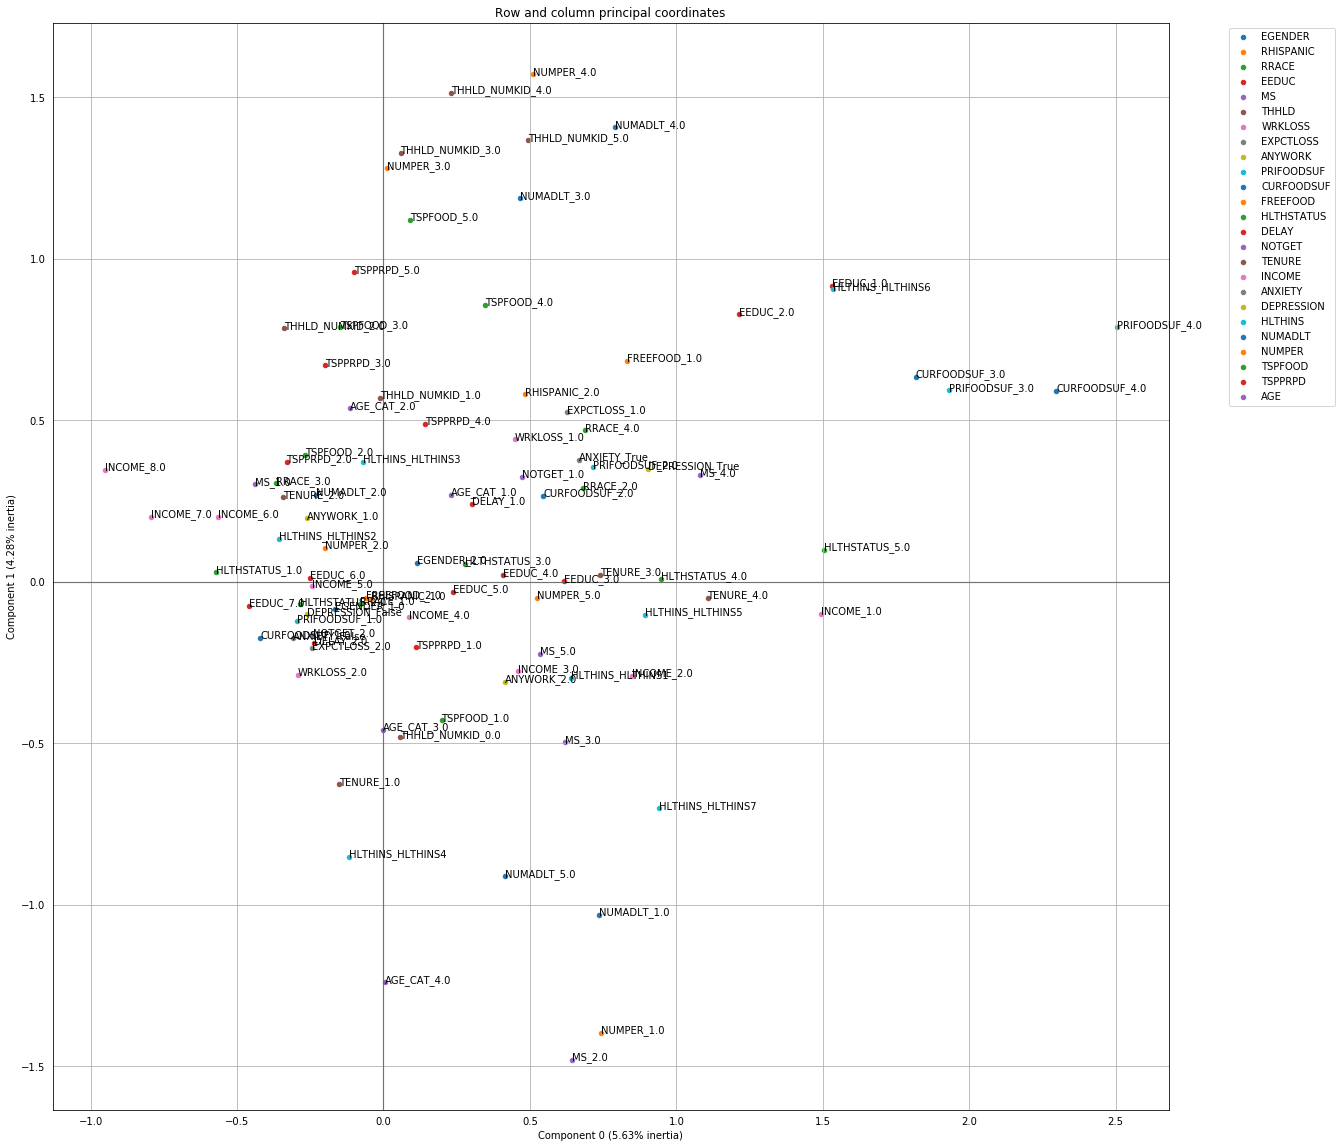

In [69]:
ax = mca_ex.plot_coordinates(
                            X=df1,
                            ax=None,
                            figsize=(20, 20),
                            show_row_points=False,
                            row_points_size=10,
                            show_row_labels=False,
                            show_column_points=True,
                            column_points_size=20,
                            show_column_labels=True,
                            legend_n_cols=1)
ax.get_figure().savefig('mca_coordinates.svg')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

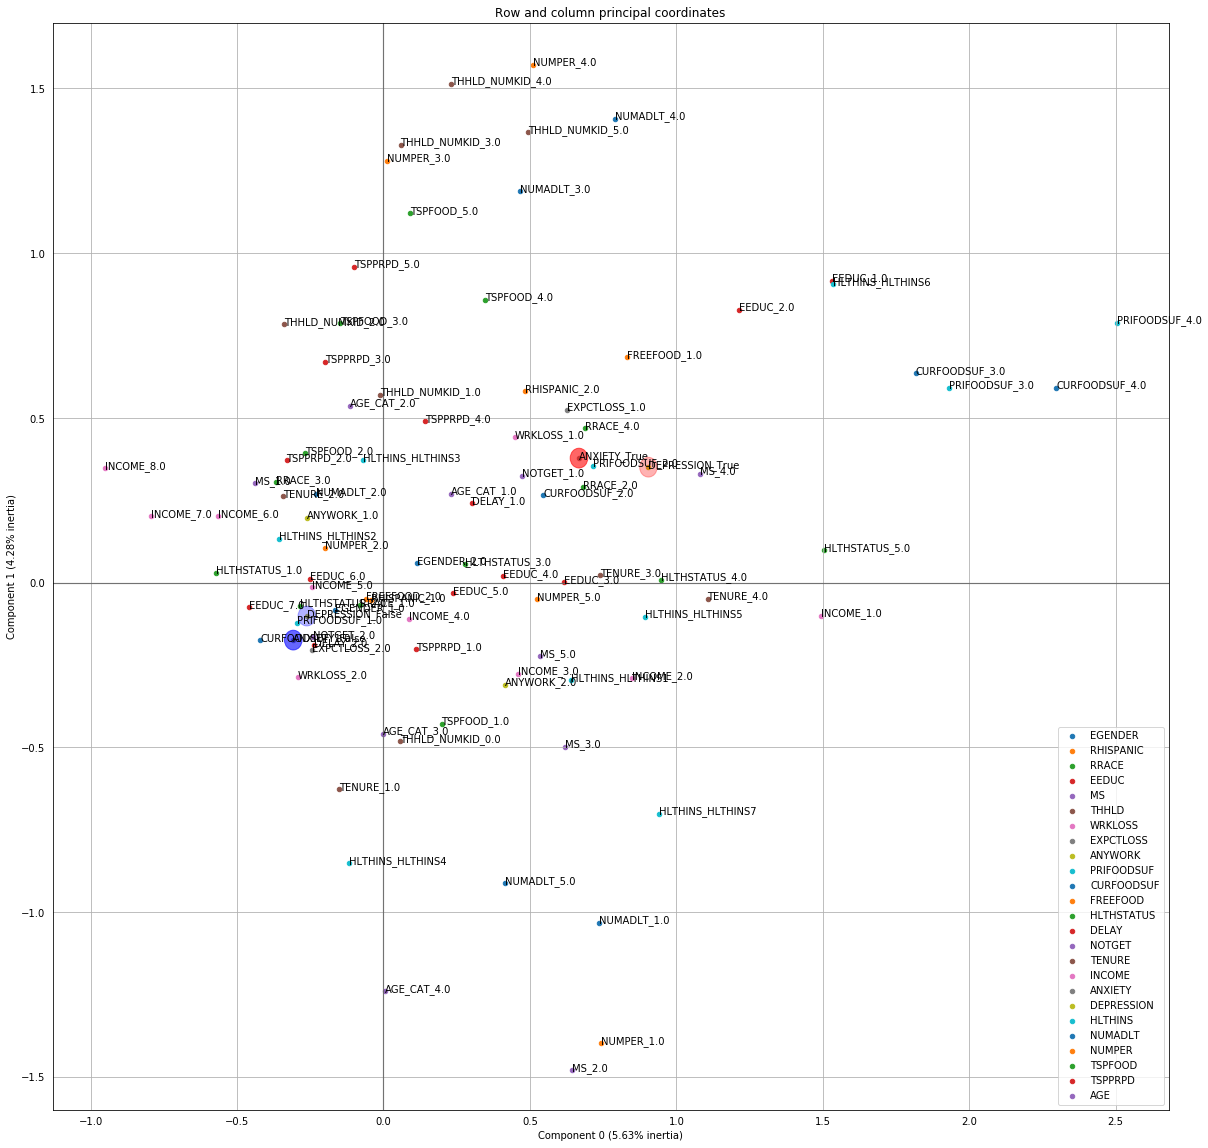

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

ax = mca_ex.plot_coordinates(
                            X=df1,
                            ax=None,
                            figsize=(20, 20),
                            show_row_points=False,
                            row_points_size=10,
                            show_row_labels=False,
                            show_column_points=True,
                            column_points_size=20,
                            show_column_labels=True,
                            legend_n_cols=1)
ax.get_figure().savefig('mca_coordinates.svg')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.legend(loc='lower right')

cir = plt.Circle(df_variables_mca.loc['ANXIETY_True', :], 0.03, color='r',fill=True, alpha=0.6)
cir1 = plt.Circle(df_variables_mca.loc['ANXIETY_False', :], 0.03, color='b',fill=True, alpha=0.6)
cir2 = plt.Circle(df_variables_mca.loc['DEPRESSION_True', :], 0.03, color='r',fill=True, alpha=0.3)
cir3 = plt.Circle(df_variables_mca.loc['DEPRESSION_False', :], 0.03, color='b',fill=True, alpha=0.3)
#ax.set_aspect('equal', adjustable='datalim')
ax.add_patch(cir)
ax.add_patch(cir1)
ax.add_patch(cir2)
ax.add_patch(cir3)
ax.set_ylim(-1.6, 1.7)
# ax.set_xlim(-0.02, 1.7)
plt.show()

In [71]:
a = df_variables_mca.loc['ANXIETY_True', 0]
b = df_variables_mca.loc['ANXIETY_True', 1]
c = df_variables_mca.loc['ANXIETY_False', 0]
d = df_variables_mca.loc['ANXIETY_False', 1]

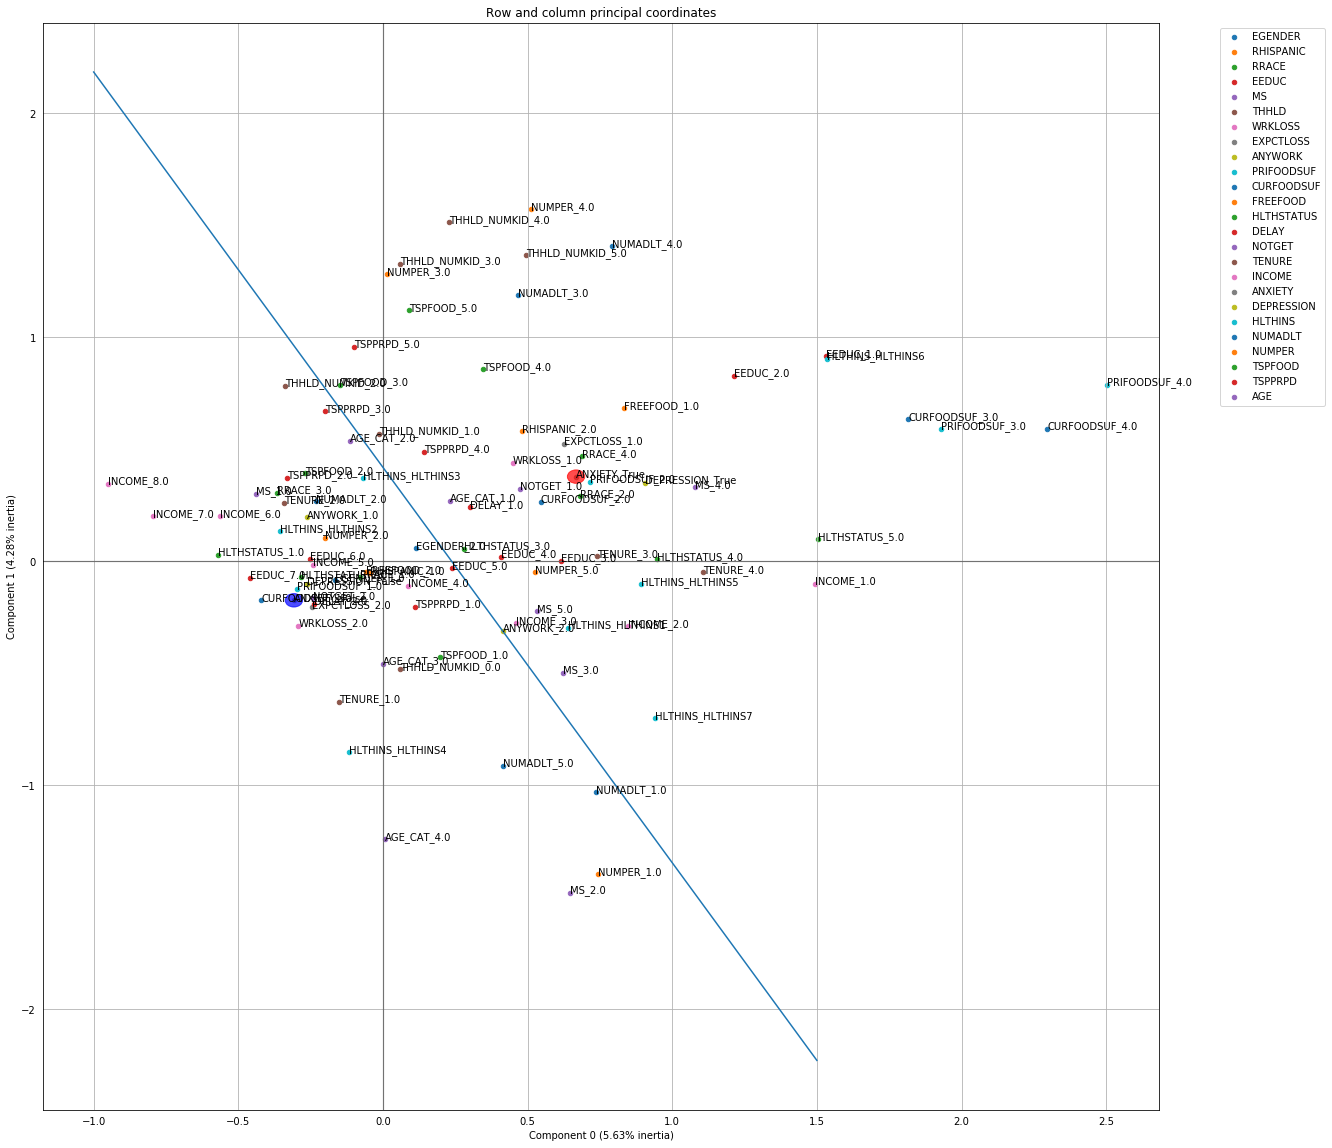

In [72]:
ax = mca_ex.plot_coordinates(
                            X=df1,
                            ax=None,
                            figsize=(20, 20),
                            show_row_points=False,
                            row_points_size=10,
                            show_row_labels=False,
                            show_column_points=True,
                            column_points_size=20,
                            show_column_labels=True,
                            legend_n_cols=1)
ax.get_figure().savefig('mca_coordinates_line.svg')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
#            linestyles=['--', '-', '--'])

x = np.linspace(-1,1.5)
y = (-(c**2+d**2-a**2-b**2) - 2*(a-c)*x)/(2*(b-d))
cir = plt.Circle(df_variables_mca.loc['ANXIETY_True', :], 0.03, color='r',fill=True, alpha=0.7)
cir1 = plt.Circle(df_variables_mca.loc['ANXIETY_False', :], 0.03, color='b',fill=True, alpha=0.7)
#ax.set_aspect('equal', adjustable='datalim')
ax.add_patch(cir)
ax.add_patch(cir1)

plt.plot(x, y)
# ax.set_ylim(-0.15, 1.5)
# ax.set_xlim(-0.02, 1.7)
plt.show()

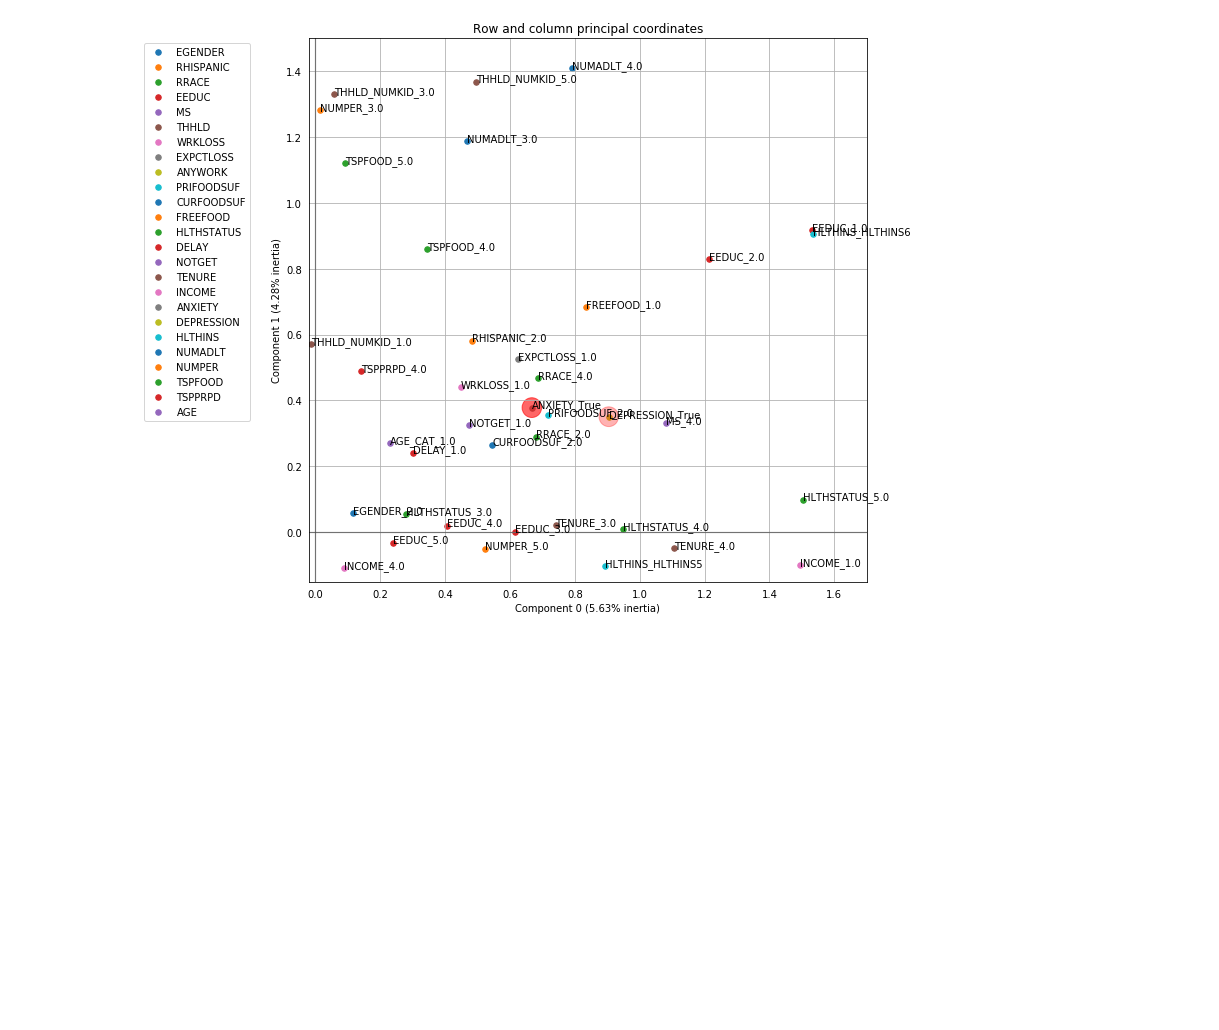

In [73]:
ax = mca_ex.plot_coordinates(
                            X=df1,
                            ax=None,
                            figsize=(10, 10),
                            show_row_points=False,
                            row_points_size=10,
                            show_row_labels=False,
                            show_column_points=True,
                            column_points_size=30,
                            show_column_labels=True,
                            legend_n_cols=1)
ax.get_figure().savefig('mca_coordinates_anxiety_true.svg')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.legend(bbox_to_anchor=(-0.2, 1), loc='upper center')

# ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
#            linestyles=['--', '-', '--'])

# x = np.linspace(-1,1.5)
# y = (-(c**2+d**2-a**2-b**2) - 2*(a-c)*x)/(2*(b-d))
cir = plt.Circle(df_variables_mca.loc['ANXIETY_True', :], 0.03, color='r',fill=True, alpha=0.6)
cir1 = plt.Circle(df_variables_mca.loc['ANXIETY_False', :], 0.03, color='b',fill=True, alpha=0.6)
cir2 = plt.Circle(df_variables_mca.loc['DEPRESSION_True', :], 0.03, color='r',fill=True, alpha=0.3)
cir3 = plt.Circle(df_variables_mca.loc['DEPRESSION_False', :], 0.03, color='b',fill=True, alpha=0.3)
#ax.set_aspect('equal', adjustable='datalim')
ax.add_patch(cir)
ax.add_patch(cir1)
ax.add_patch(cir2)
ax.add_patch(cir3)

# plt.plot(x, y)
ax.set_ylim(-0.15, 1.5)
ax.set_xlim(-0.02, 1.7)
plt.show()

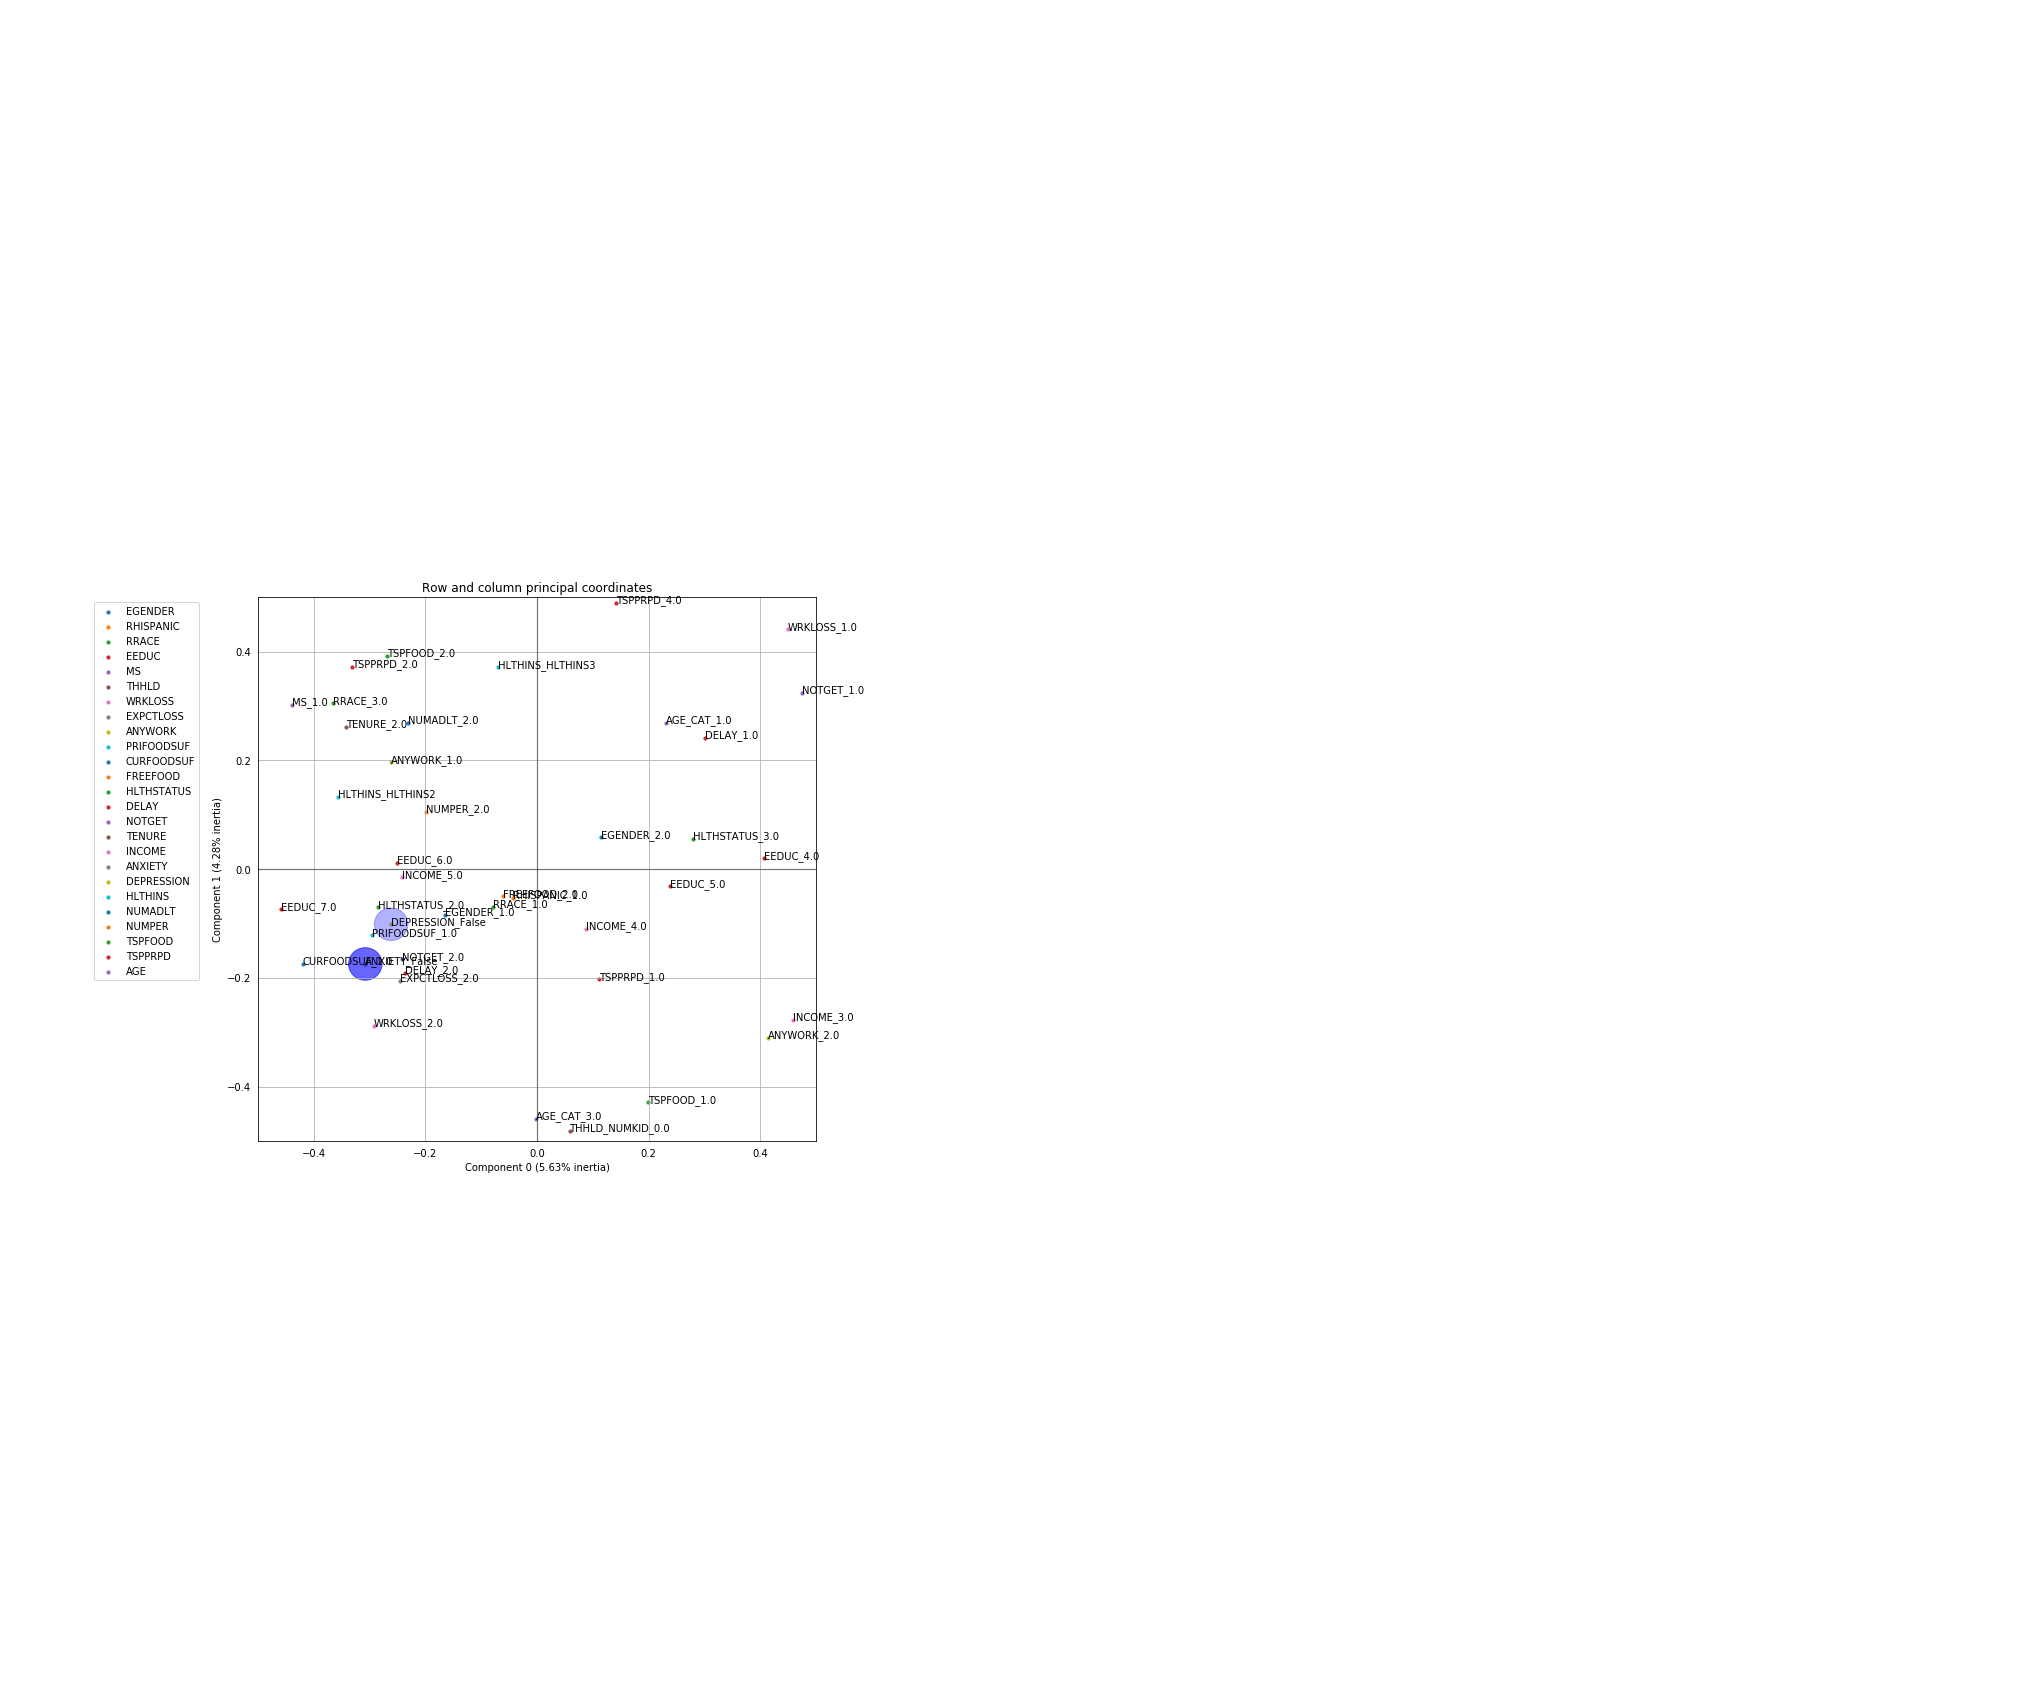

In [74]:
ax = mca_ex.plot_coordinates(
                            X=df1,
                            ax=None,
                            figsize=(10, 10),
                            show_row_points=False,
                            row_points_size=10,
                            show_row_labels=False,
                            show_column_points=True,
                            column_points_size=10,
                            show_column_labels=True,
                            legend_n_cols=1)
ax.get_figure().savefig('mca_coordinates_anxiety_false.svg')
ax.legend(bbox_to_anchor=(-0.2, 1), loc='upper center')

# ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
#            linestyles=['--', '-', '--'])

# x = np.linspace(-1,1.5)
# y = (-(c**2+d**2-a**2-b**2) - 2*(a-c)*x)/(2*(b-d))
cir = plt.Circle(df_variables_mca.loc['ANXIETY_True', :], 0.03, color='r',fill=True, alpha=0.6)
cir1 = plt.Circle(df_variables_mca.loc['ANXIETY_False', :], 0.03, color='b',fill=True, alpha=0.6)
cir2 = plt.Circle(df_variables_mca.loc['DEPRESSION_True', :], 0.03, color='r',fill=True, alpha=0.3)
cir3 = plt.Circle(df_variables_mca.loc['DEPRESSION_False', :], 0.03, color='b',fill=True, alpha=0.3)
#ax.set_aspect('equal', adjustable='datalim')
ax.add_patch(cir)
ax.add_patch(cir1)
ax.add_patch(cir2)
ax.add_patch(cir3)

# plt.plot(x, y)
ax.set_ylim(-0.5, 0.5)
ax.set_xlim(-0.5, 0.5)
# ax.margins(y=-0.35) 
plt.show()

### 2. Plot datapoints

In [75]:
df1_codes = df1.replace(
                {
                'EGENDER': {1.0: 'Man', 2.0: 'Woman'},
                'RHISPANIC': {1.0: 'No latino', 2.0: 'Latino'},
                'INCOME': {1.0: 'Less than $25,000',
                           2.0: 'Between $25,000- $34,999',
                           3.0: 'Between $35,000- $49,999',
                           4.0: 'Between $50,000- $74,999',
                           5.0: 'Between $75,000- $99,999',
                           6.0: 'Between $100,000- $149,999',
                           7.0: 'Between $150,000- $199,999',
                           8.0: '$200,000 and above'},
                'HLTHSTATUS': {1.0: 'Excellent', 2.0: 'Very good', 3.0: 'Good', 4.0: 'Fair', 5.0: 'Poor'},
                'TENURE': {1.0: 'Owned', 2.0: 'Owned+loan', 3.0: 'Rented', 4.0:'Occupied no payment'},
                'NOTGET': {1.0: 'Yes', 2.0: 'No'},
                'DELAY': {1.0: 'Yes', 2.0: 'No'},
                'CURFOODSUF': {1.0: 'Enough what they want to eat', 
                               2.0: 'Enough, not always what they want to eat', 
                               3.0: 'Sometimes not enough', 
                               4.0: 'Often not enough'},
                'AGE_CAT': {1.0: '<36 yrs', 
                            2.0: 'Between 36-54 yrs', 
                            3.0: 'Between 54-72 yrs', 
                            4.0: '>= 72 yrs'}
                })

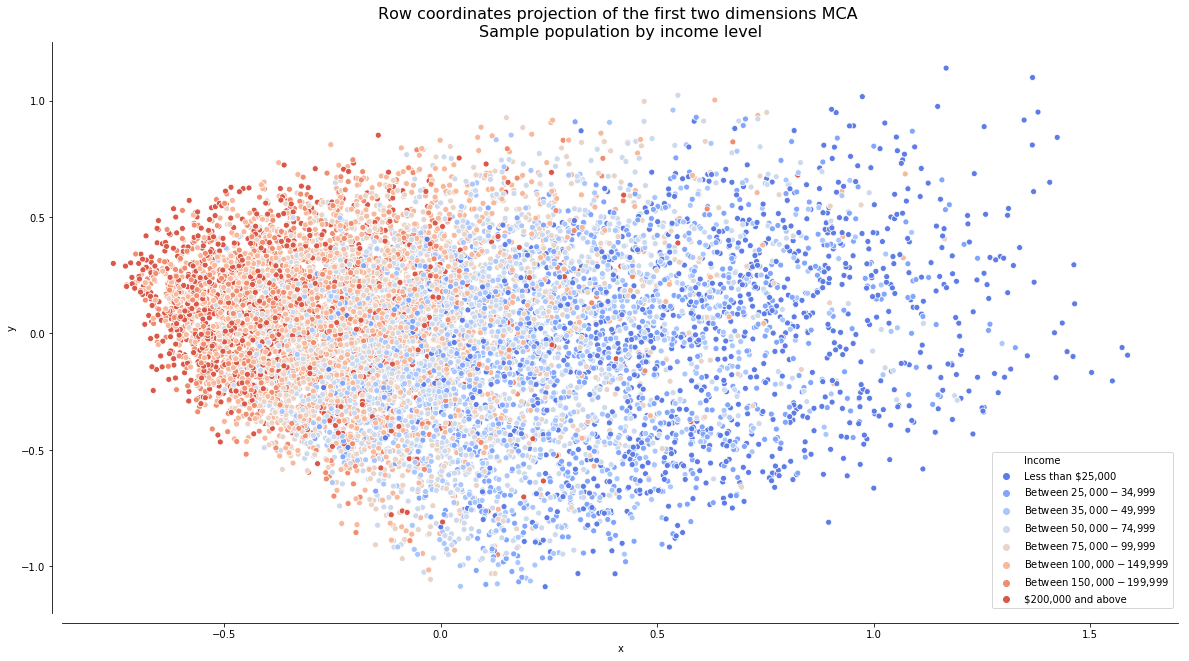

In [76]:
df_mca = pd.DataFrame({'id': df1_codes.index,
                       'Income': df1_codes.INCOME,
                       'Gender': df1_codes.EGENDER,
                       'Age': df1_codes.AGE_CAT,
                       'Tenure': df1_codes.TENURE,
                       'ANXIETY': df1_codes.ANXIETY,
                       'DEPRESSION': df1_codes.DEPRESSION,
                       'Not_get': df1_codes.NOTGET,
                       'Delay':  df1_codes.DELAY,
                       'Health_status': df1_codes.HLTHSTATUS,
                       'Food_sufficiency': df1_codes.CURFOODSUF,
                       'x': dfmca[0], 
                       'y': dfmca[1]})

f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', hue='Income', hue_order= ["Less than $25,000", 
                                                            "Between $25,000- $34,999", 
                                                            'Between $35,000- $49,999', 
                                                            "Between $50,000- $74,999", 
                                                            "Between $75,000- $99,999", 
                                                            "Between $100,000- $149,999", 
                                                            "Between $150,000- $199,999", 
                                                            "$200,000 and above"],
                    data=df_mca, palette='coolwarm')
_ = plt.title('Row coordinates projection of the first two dimensions MCA \nSample population by income level', size=16)
_ = plt.show()

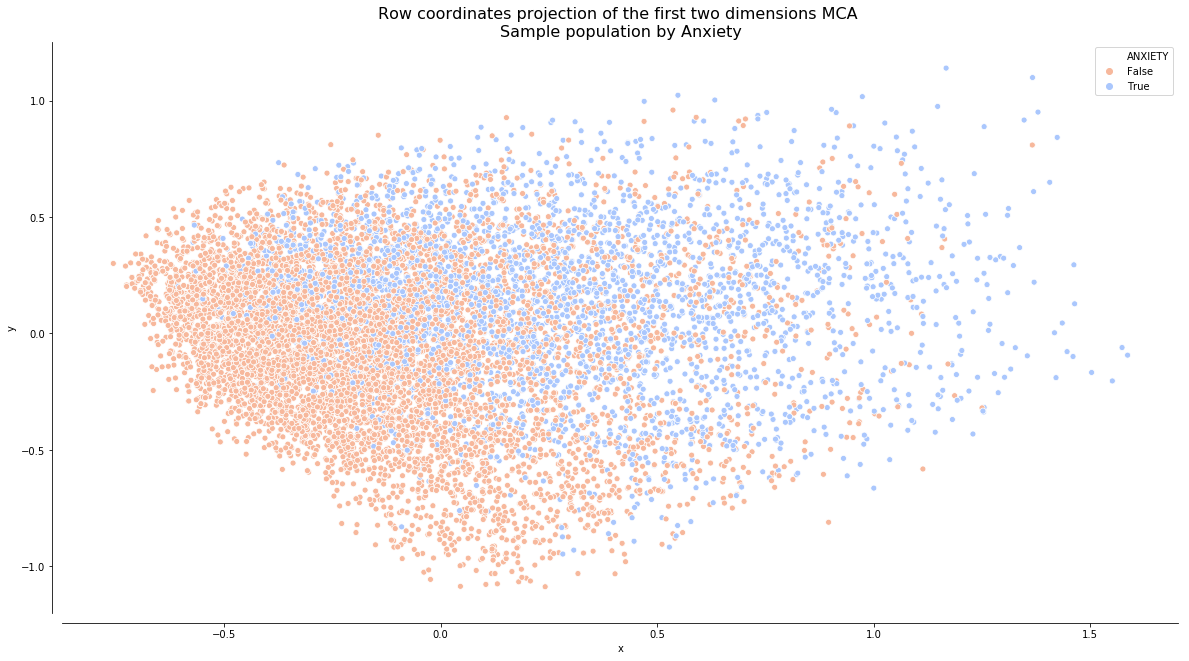

In [77]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', hue='ANXIETY',
                    data=df_mca, palette='coolwarm_r')
_ = plt.title('Row coordinates projection of the first two dimensions MCA \nSample population by Anxiety', size=16)
_ = plt.show()

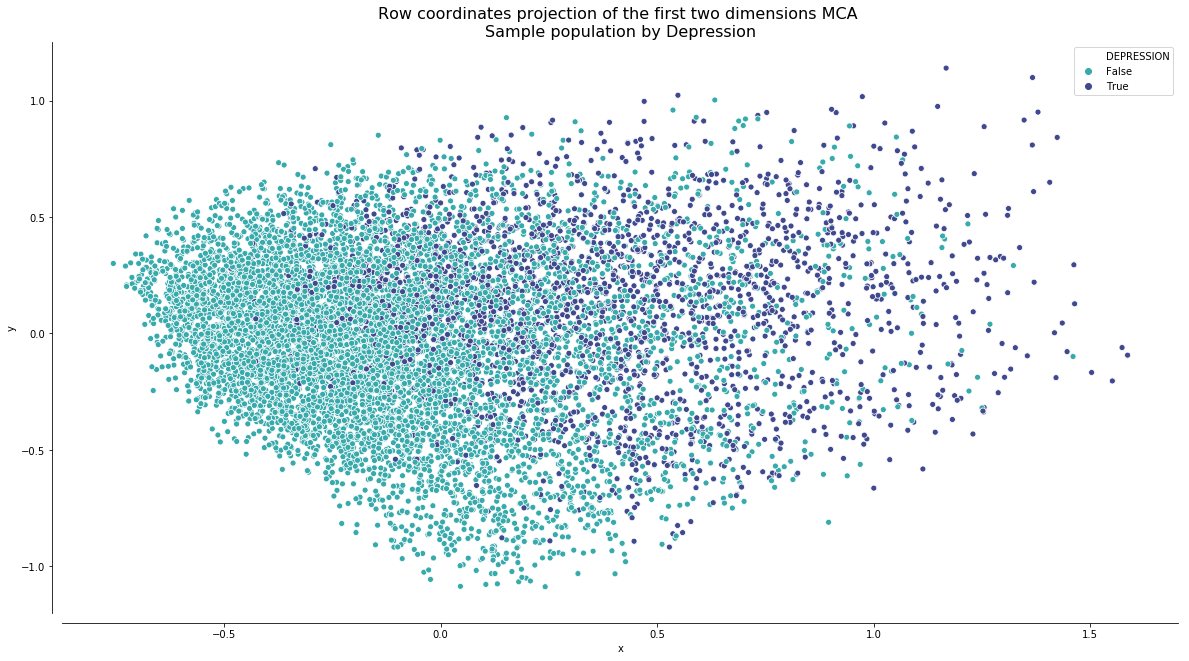

In [78]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', hue='DEPRESSION',
                    data=df_mca, palette='mako_r')
_ = plt.title('Row coordinates projection of the first two dimensions MCA \nSample population by Depression', size=16)
_ = plt.show()

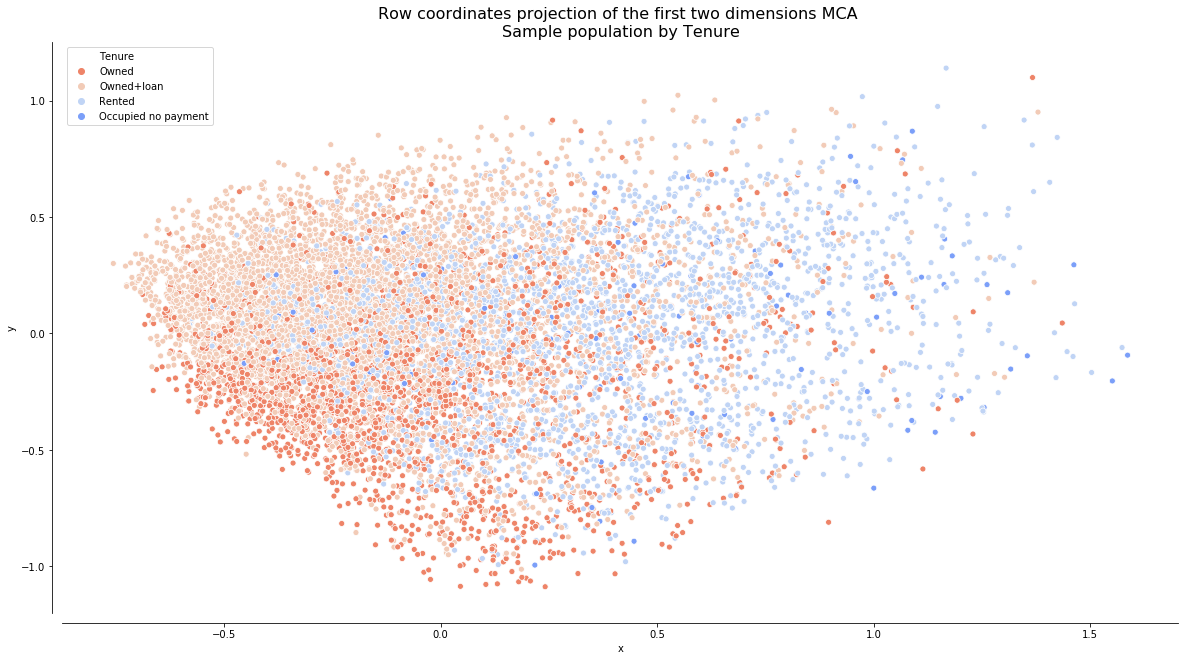

In [79]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', hue='Tenure',
                    data=df_mca, palette='coolwarm_r')
_ = plt.title('Row coordinates projection of the first two dimensions MCA \nSample population by Tenure', size=16)
_ = plt.show()

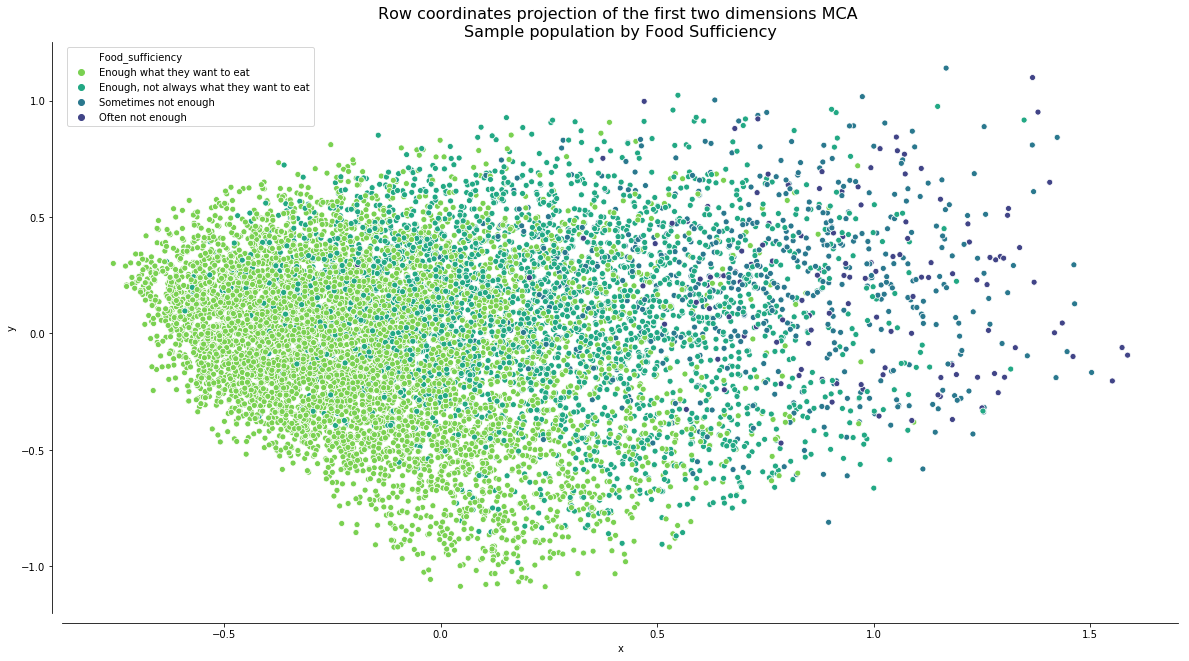

In [80]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', hue='Food_sufficiency', hue_order = ['Enough what they want to eat', 
                                                                       'Enough, not always what they want to eat', 
                                                                       'Sometimes not enough', 
                                                                       'Often not enough'],
                    data=df_mca, palette='viridis_r')
_ = plt.title('Row coordinates projection of the first two dimensions MCA \nSample population by Food Sufficiency', size=16)
_ = plt.show()

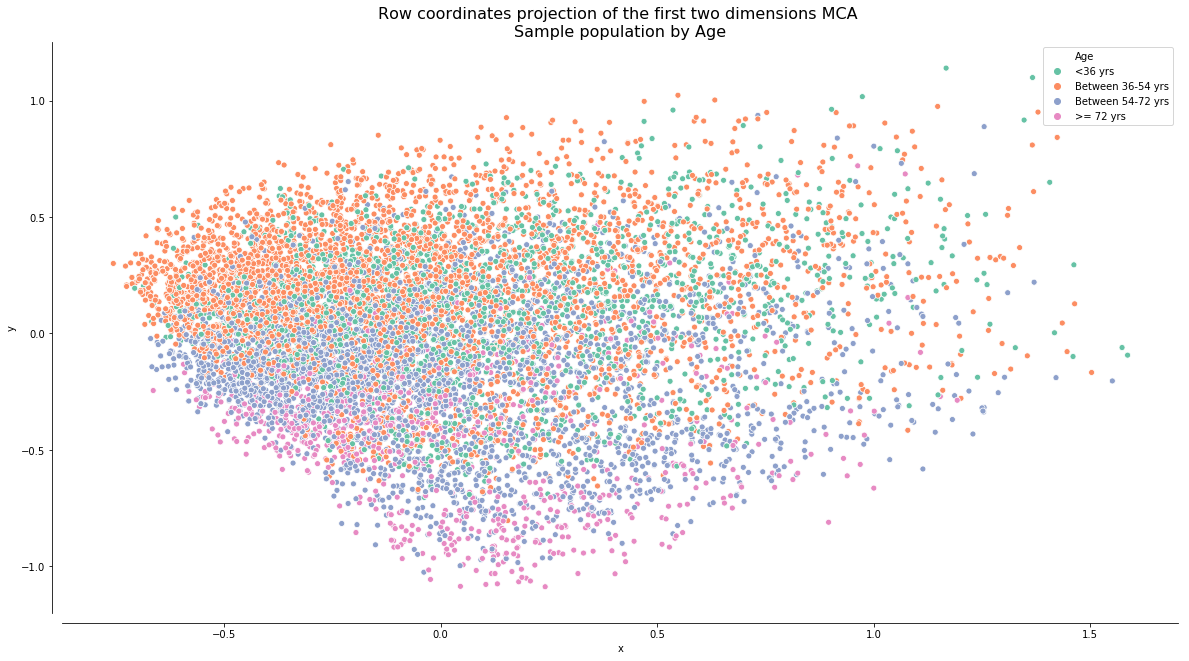

In [81]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', hue='Age', hue_order= ["<36 yrs", 
                                                        "Between 36-54 yrs", 
                                                        "Between 54-72 yrs", 
                                                        ">= 72 yrs"],
                    data=df_mca, palette='Set2')
_ = plt.title('Row coordinates projection of the first two dimensions MCA \nSample population by Age', size=16)
_ = plt.show()